![Egeria Logo](https://raw.githubusercontent.com/odpi/egeria/master/assets/img/ODPi_Egeria_Logo_color.png)

### Egeria Hands-On Lab
# Welcome to the Performance Test Suite Results Lab

## Introduction

Egeria is an open source project that provides open standards and implementation libraries to connect tools, catalogs and platforms together so they can share information (called metadata) about data and the technology that supports it.

In this hands-on lab you will get a chance to analyze the results of running a performance test suite against a repository. This assumes you have already followed the [run-performance-test-suite.ipynb](run-performance-test-suite.ipynb) lab, or another method, to produce such results.

## About the Performance Suite 

The Performance Suite can be used to test a Repository Connector to record the performance of its various repository methods.

This lab more deeply analyzes the results produced from running the Repository Performance Workbench.

## About the Results

Before running this lab, you will need to have some results to analyze. As mentioned in the introduction, this could be by running through the Performance Test Suite Lab or through other means.

Irrespective of how you have run the suite, you will need to have the following files available:

- `profile-details/*.json` (there should be one such JSON file for each profile of the Performance Suite).

You may have other files as well (such as `test-case-details/*.json`), but at the moment these are not used by this lab.

## Specify the location of the results

This lab does not actually require a running Egeria instance, since we will only be analyzing the results that have already been produced.

Instead, we need to start by specifying a preferred name for how we will refer to the results, and the actual location of those results.

In [1]:
primary_results_name       = "Crux"
primary_results_location   = "crux-5-2-rocks"

The following method will simply verify that the defined locations exist:

In [2]:
import os

def validateProfileResultsLocation(location):
    profile_details_location = location + os.path.sep + "profile-details"
    print("Validating profile-details location:", profile_details_location)
    if os.path.isdir(profile_details_location):
        print(" ... directory exists.")
    else:
        print(" ... ERROR: could not find this directory. Is the location specified correct?")

validateProfileResultsLocation(primary_results_location)

Validating profile-details location: crux-5-2-rocks/profile-details
 ... directory exists.


## Parsing details

Now that we have the location of the results, we will parse the JSON files for each profile into Python data structures (specifically, a Pandas dataframe) that we can then use for deeper analysis and visualization.

To do this, we will define a number of re-usable functions as follows:

### `parseEvidence`

Parses all of the `positiveTestEvidence` objects from a given set of requirement results in a profile, in order to capture the detailed information about the specific method that was invoked, its execution time, which test case it was running, its assertion, etc.

### `parseRequirementResults`

Parses all of the requirement results objects from a given profile, in order to hand these off to `parseEvidence` to process.

### `getAllProfiles`

Retrieves all of the profile JSON files from the `profile-details` directory of the specified results location.

### `parseProfileDetailsIntoDF`

Parses the details of a given profile result JSON file into a dataframe.

In [3]:
import json
import pandas as pd

# Define the profile ordering
profile_order=[
    'Entity creation', 'Entity search', 'Relationship creation', 'Relationship search',
    'Entity classification', 'Classification search', 'Entity update', 'Relationship update',
    'Classification update', 'Entity undo', 'Relationship undo', 'Entity retrieval', 'Entity history retrieval',
    'Relationship retrieval', 'Relationship history retrieval', 'Entity history search', 'Relationship history search',
    'Graph queries', 'Graph history queries', 'Entity re-home', 'Relationship re-home', 'Entity declassify',
    'Entity re-type', 'Relationship re-type', 'Entity re-identify', 'Relationship re-identify',
    'Relationship delete', 'Entity delete', 'Entity restore', 'Relationship restore', 'Relationship purge',
    'Entity purge'
]

# Given a profileResult.requirementResults object, parse all of its positiveTestEvidence
# and group the results by methodName
def parseEvidence(df, repositoryName, requirementResults):
    if (requirementResults is not None and 'positiveTestEvidence' in requirementResults):
        print("Parsing evidence for:", requirementResults['name'], "(" + repositoryName + ")")
        data_array = []
        for evidence in requirementResults['positiveTestEvidence']:
            if ('methodName' in evidence and 'elapsedTime' in evidence):
                data = {
                    'repo': repositoryName,
                    'method_name': evidence['methodName'],
                    'elapsed_time': evidence['elapsedTime'],
                    'profile_name': requirementResults['name'],
                    'test_case_id': evidence['testCaseId'],
                    'assertion_id': evidence['assertionId']
                }
                data_array.append(data)
        df = df.append(pd.read_json(json.dumps(data_array), orient='records'), ignore_index=True)
    return df

# Given a profile detail JSON file, retrieve all of its profileResult.requirementResults[] objects
def parseRequirementResults(profileFile):
    with open(profileFile) as f:
        profile = json.load(f)
    # This first case covers files retrieved via API
    if ('profileResult' in profile and 'requirementResults' in profile['profileResult']):
        return profile['profileResult']['requirementResults']
    # This second case covers files created by the CLI client
    elif ('requirementResults' in profile):
        return profile['requirementResults']
    else:
        return None

# Retrieve a listing of all of the profile detail JSON files
def getAllProfiles(profileLocation):
    detailsLocation = profileLocation + os.path.sep + "profile-details"
    _, _, filenames = next(os.walk(detailsLocation))
    full_filenames = []
    for filename in filenames:
        full_filenames.append(detailsLocation + os.path.sep + filename)
    return full_filenames

# Parse all of the provided profile file's details into the provided dataframe
def parseProfileDetailsIntoDF(df, profileFile, qualifier):
    profileResults = parseRequirementResults(profileFile)
    if profileResults is not None:
        for result in profileResults:
            df = parseEvidence(df, qualifier, result)
    return df

Now we will simply retrieve all of the profile detail files, and for each one we will parse its details and append them into the DataFrame we will use for later analysis and visualization.

In [4]:
primary_files = getAllProfiles(primary_results_location)

df1 = pd.DataFrame({'repo': [], 'method_name': [], 'elapsed_time': [], 'profile_name': [], 'test_case_id': [], 'assertion_id': []})

for profile_file in primary_files:
    df1 = parseProfileDetailsIntoDF(df1, profile_file, primary_results_name)

Parsing evidence for: Relationship undo (Crux)
Parsing evidence for: Relationship history search (Crux)
Parsing evidence for: Classification update (Crux)
Parsing evidence for: Entity update (Crux)
Parsing evidence for: Graph queries (Crux)
Parsing evidence for: Relationship purge (Crux)
Parsing evidence for: Entity history retrieval (Crux)
Parsing evidence for: Relationship update (Crux)
Parsing evidence for: Entity creation (Crux)
Parsing evidence for: Relationship creation (Crux)
Parsing evidence for: Performance tests (Crux)
Parsing evidence for: Entity history search (Crux)
Parsing evidence for: Entity classification (Crux)
Parsing evidence for: Entity retrieval (Crux)
Parsing evidence for: Relationship delete (Crux)
Parsing evidence for: Relationship history retrieval (Crux)
Parsing evidence for: Relationship search (Crux)
Parsing evidence for: Entity declassify (Crux)
Parsing evidence for: Entity undo (Crux)
Parsing evidence for: Entity search (Crux)
Parsing evidence for: Relati

## Visualizing the result details

Now that we have a Python-native format for the detailed information, we can begin visualizing the results.

We will first define some methods to carry out this deeper analysis. These work as follows:

### `plotProfile`

Provided a dataframe and profile name, renders a histogram showing the distribution of elapsed times for each method within the specified performance test profile. The histogram shows the number of times that method was called on the Y axis resulting in a specific elapsed response time (in milliseconds) on the X axis. (Overlaid on the histogram is a kernel density estimation showing an approximate continuous distribution of the elapsed time of the responses.)

### `slowestRunning`

Provided a dataframe and profile name, shows the top-10 slowest-running methods. You can also optionally provide the number to display (rather than the default of 10) and a specific method name to further filter the results.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def plotProfile(df, profileName, remove_outliers=False):
    dfX = df[df['profile_name'] == profileName]
    # Only attempt to plot if there is anything left in the dataframe
    if not dfX.empty:
        if remove_outliers:
            # If we have been asked to remove outliers, drop anything outside the 2nd and 98th percentiles
            dfX = dfX[dfX['elapsed_time'].between(dfX['elapsed_time'].quantile(.02), dfX['elapsed_time'].quantile(.98))]
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")
        fix, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
        # Display the methods within the profile in alphabetical order for consistency
        methods = dfX['method_name'].unique()
        figure = sns.histplot(ax=axs, data=dfX, x="elapsed_time", hue="method_name",
                              hue_order=sorted(methods), kde=True, discrete=True)
        figure.set(xlabel="Elapsed time (ms)")
        figure.set_title(profileName)
        figure.get_legend().set(title='Method')
        display(fix)
        plt.close(fix)

def slowestRunning(df, profileName, num=10, methodName=None):
    dfX = df[df['profile_name'] == profileName]
    if methodName:
        dfX = dfX[dfX['method_name'] == methodName]
    if not dfX.empty:
        pd.set_option('display.max_colwidth', None)
        display(dfX.sort_values(by=['elapsed_time'], ascending=False).head(num))

With our methods defined, we can now visualize the results simply by calling them with appropriate parameters.

### Visualizing each profile's response times

The following plots the response times of each method within each profile, in the order that the profiles themselves were executed within the performance suite. (As this is rendering 30+ detailed visualizations it may take a little time to complete.)

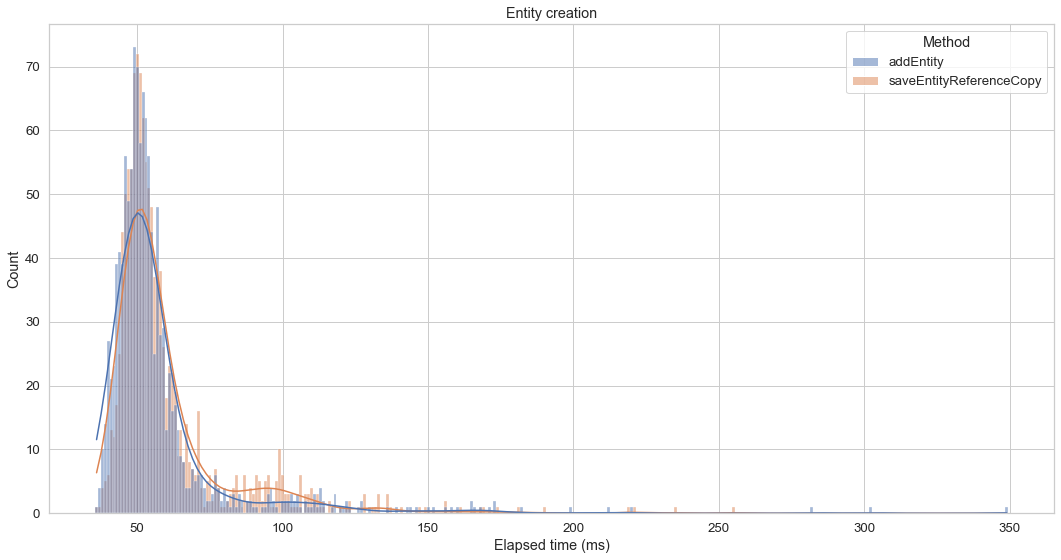

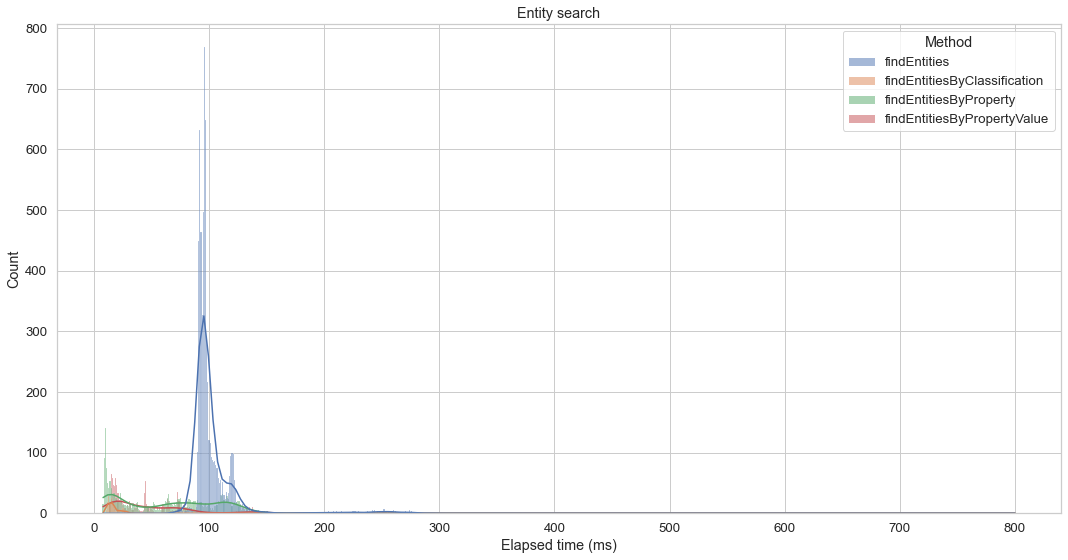

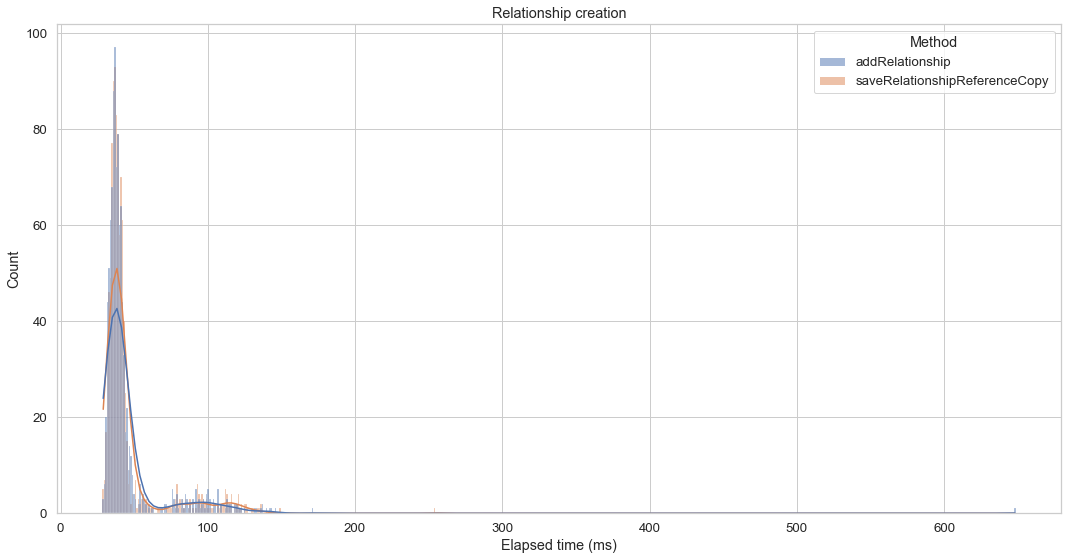

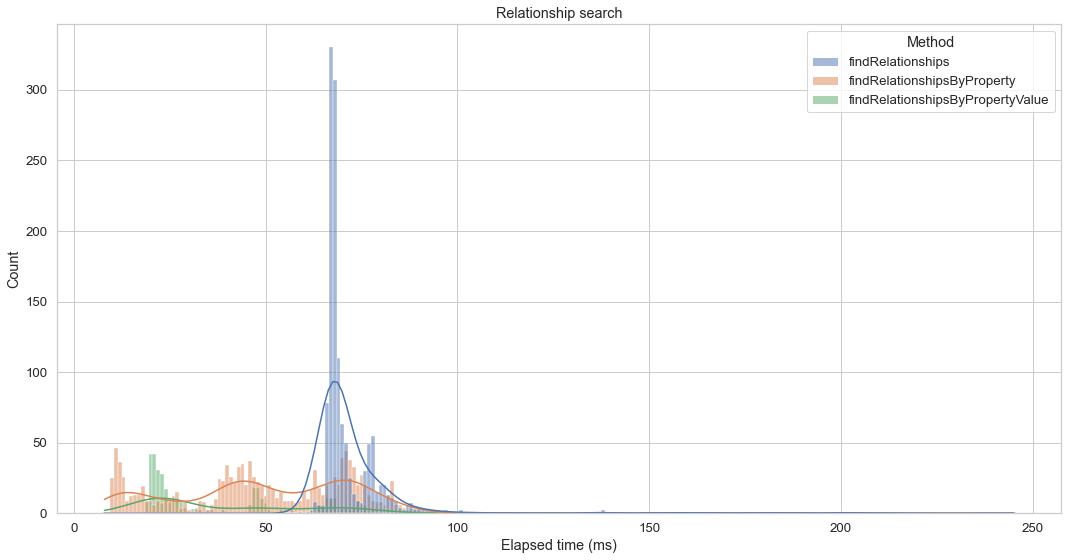

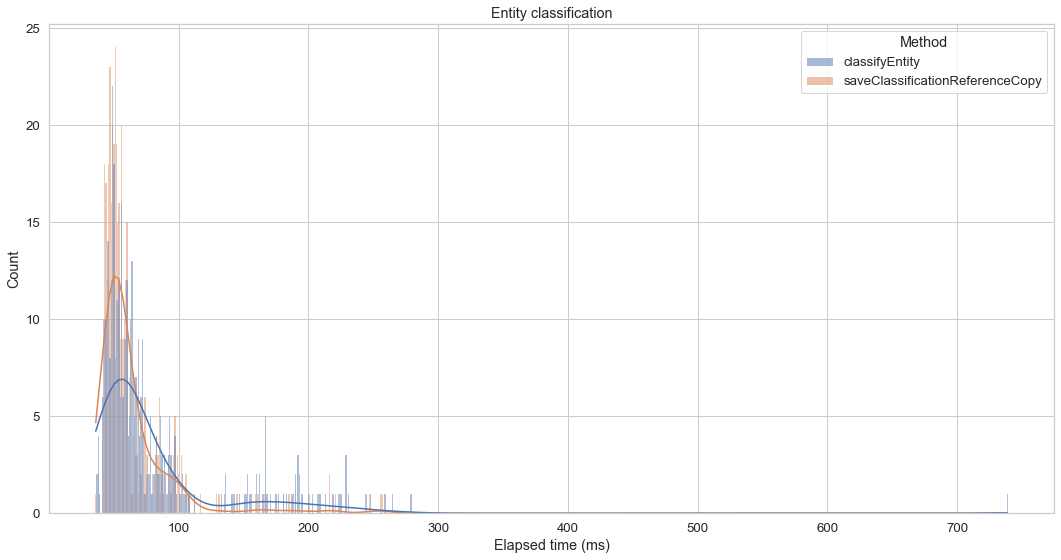

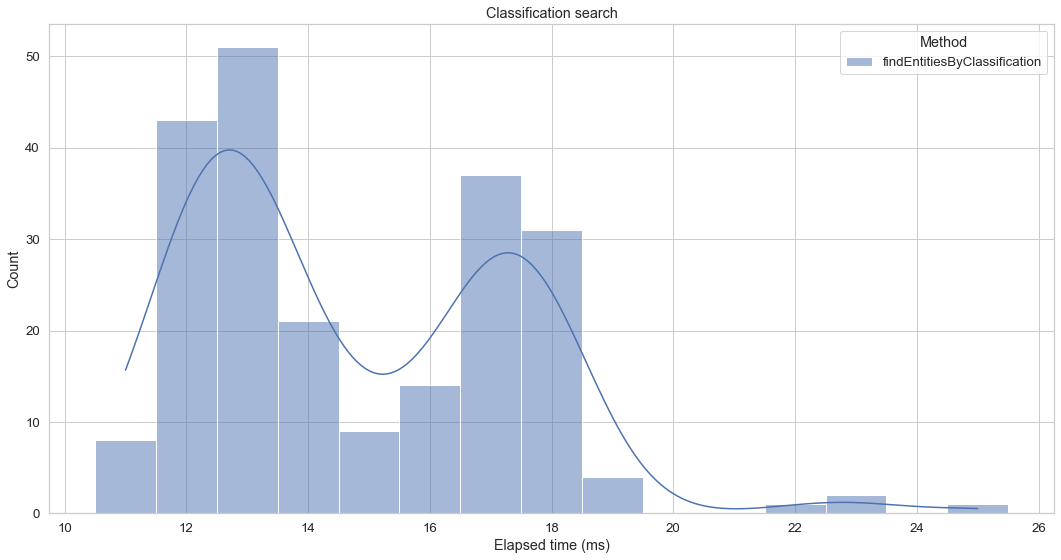

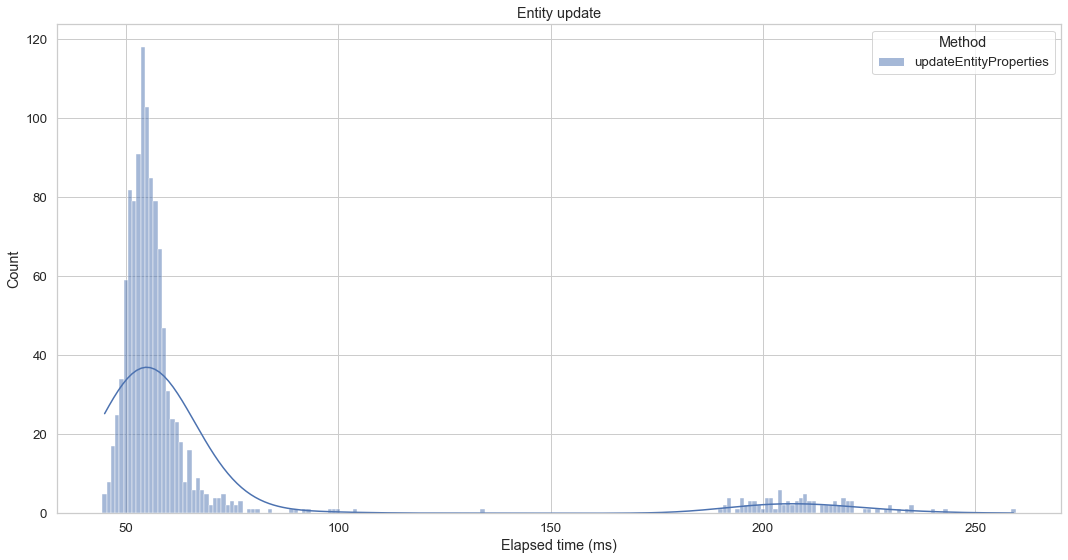

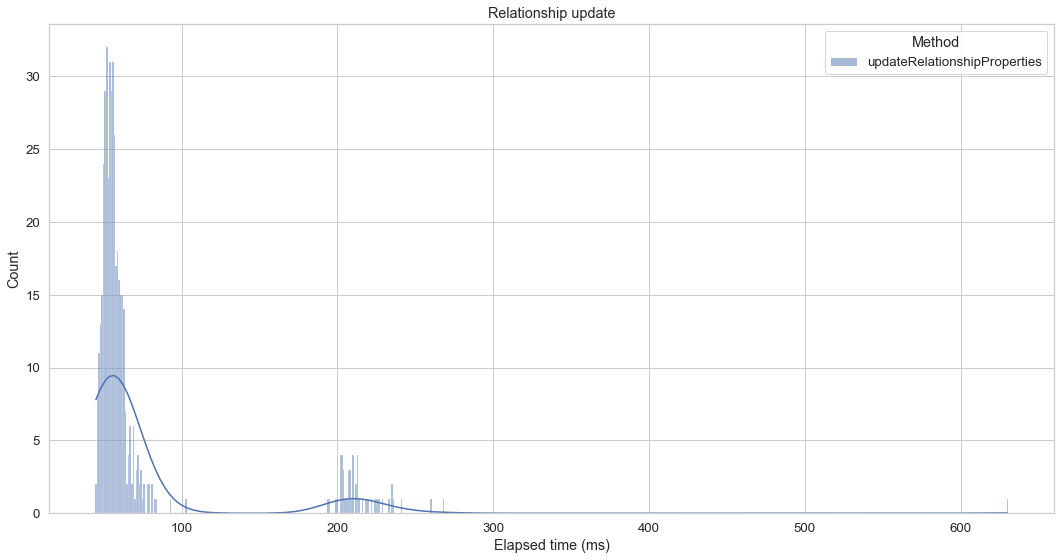

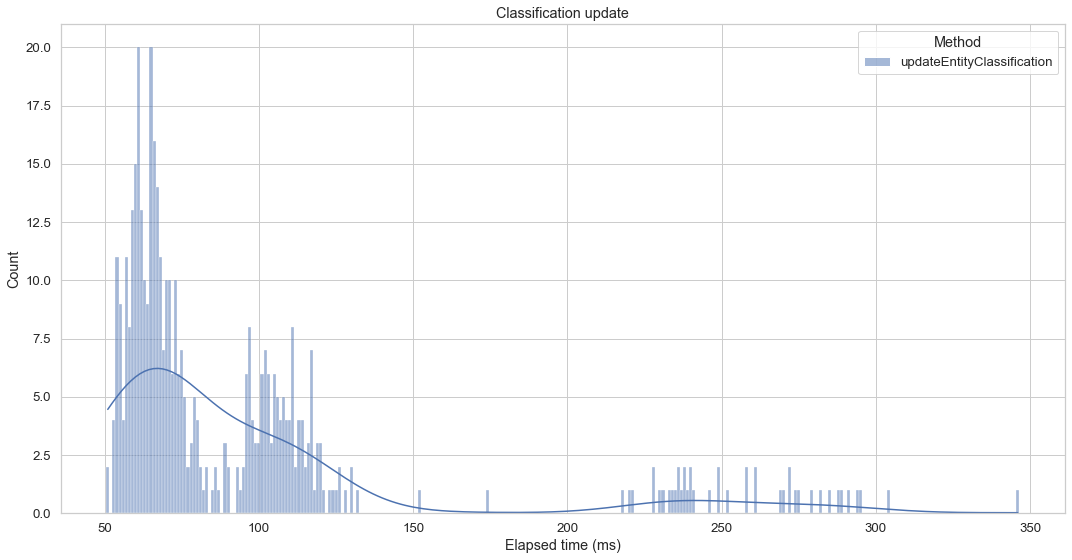

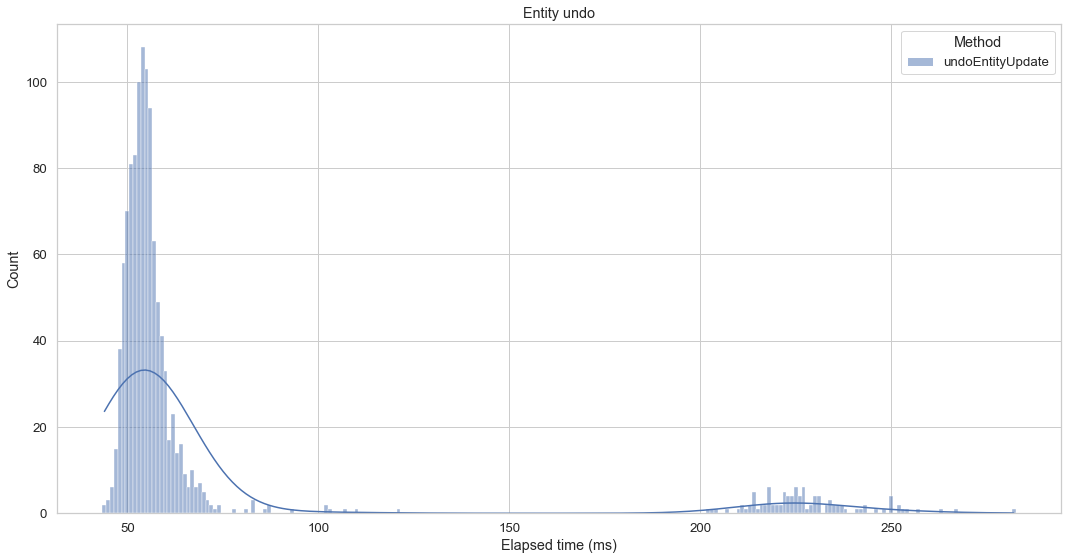

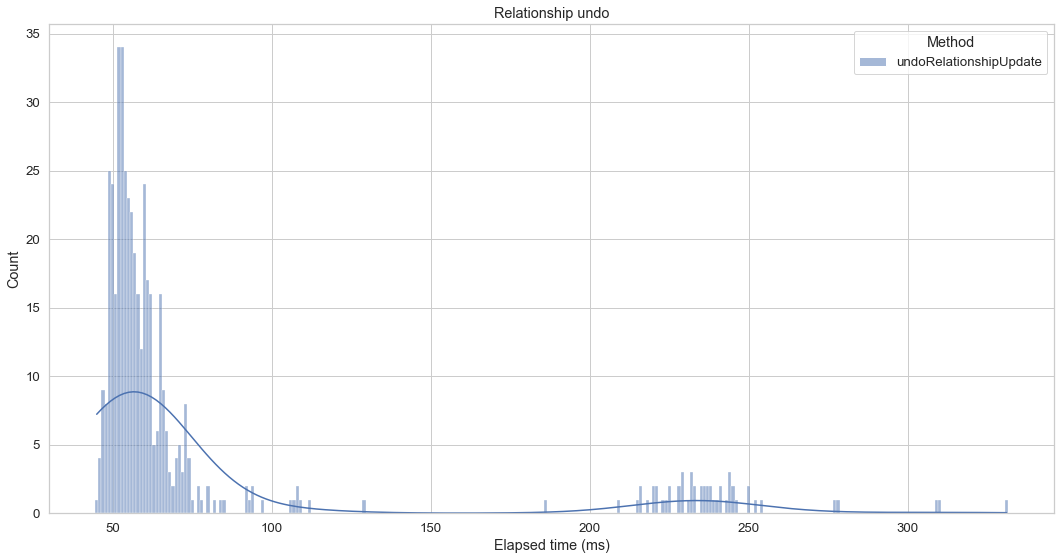

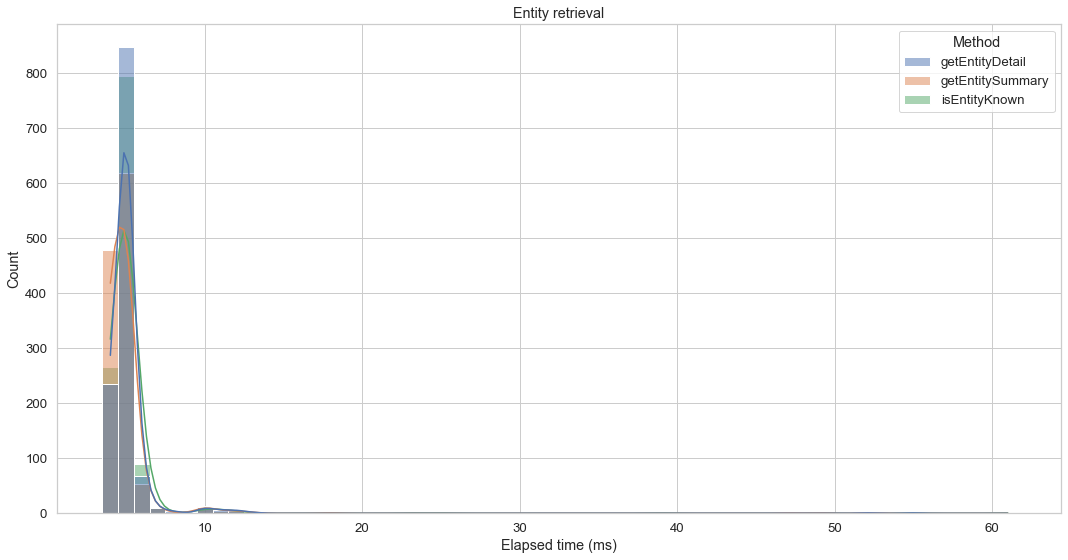

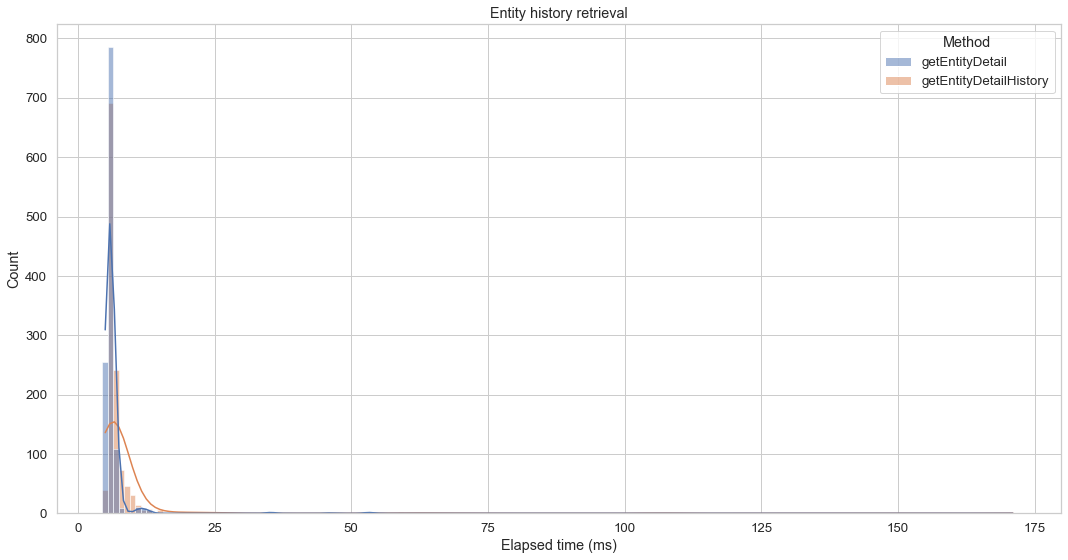

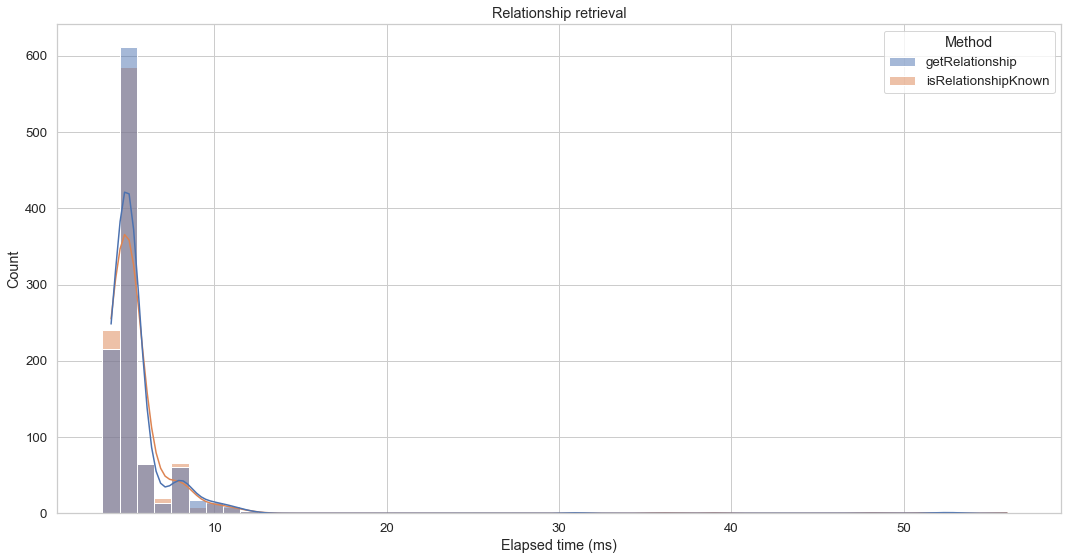

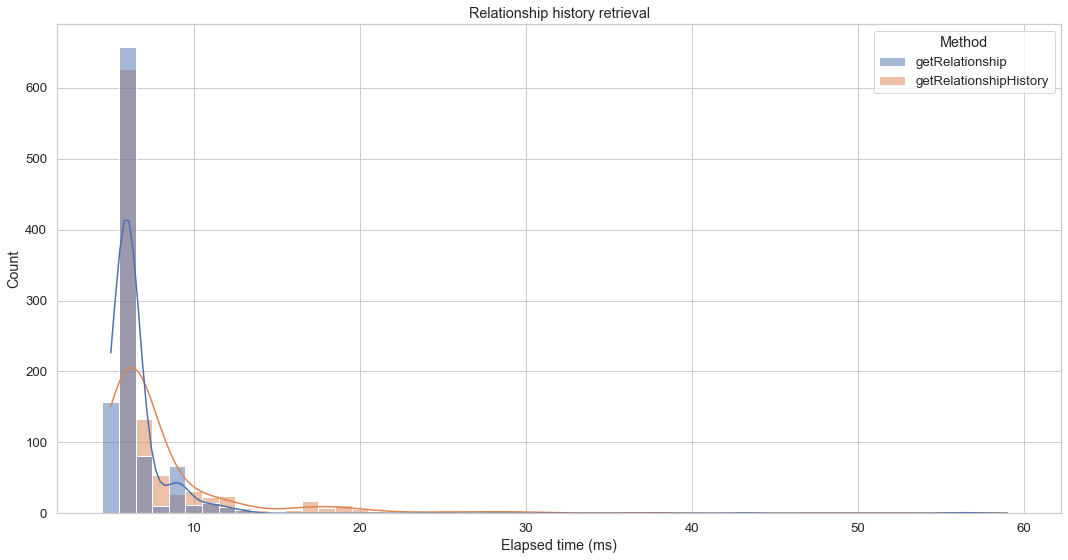

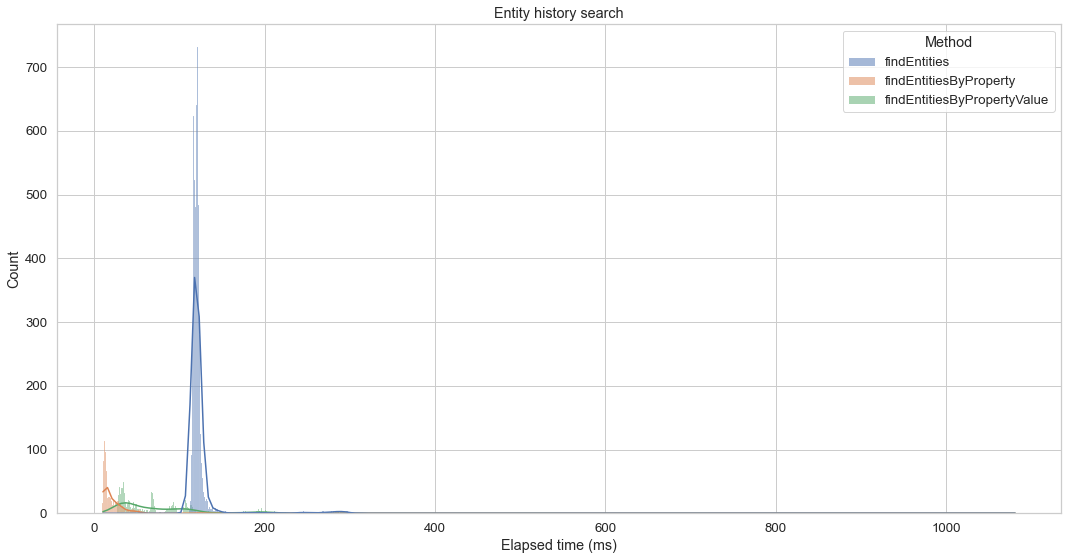

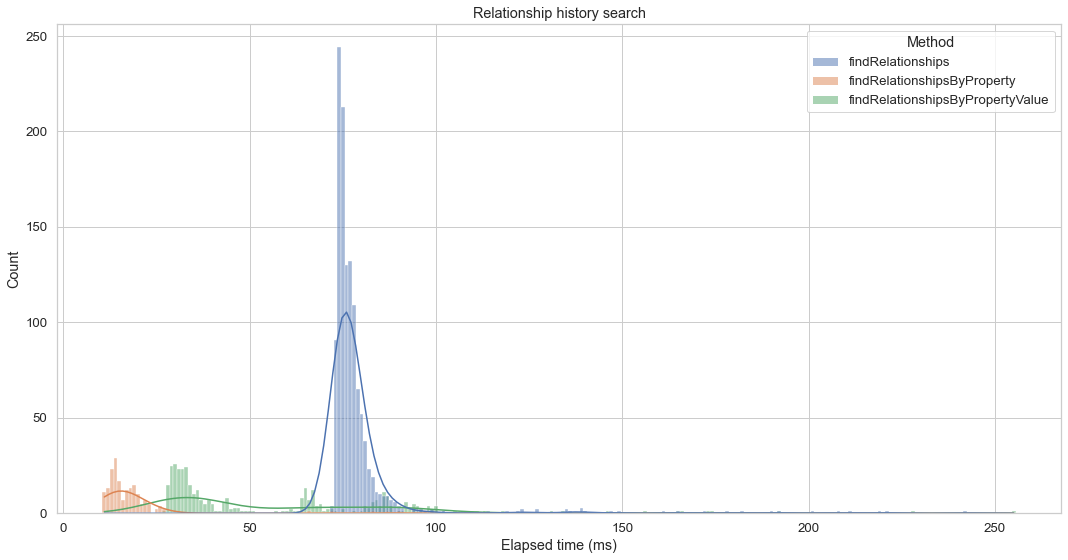

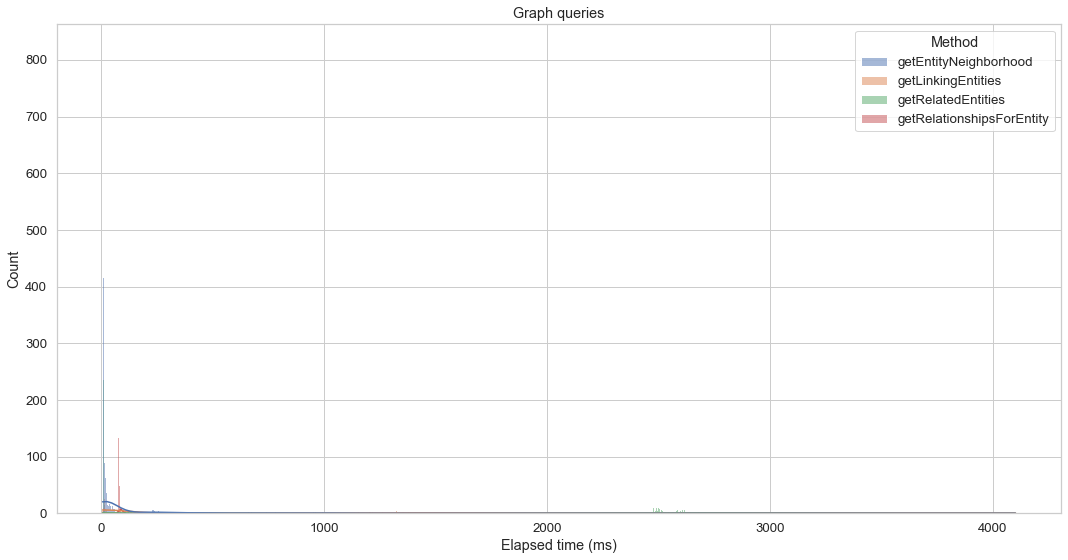

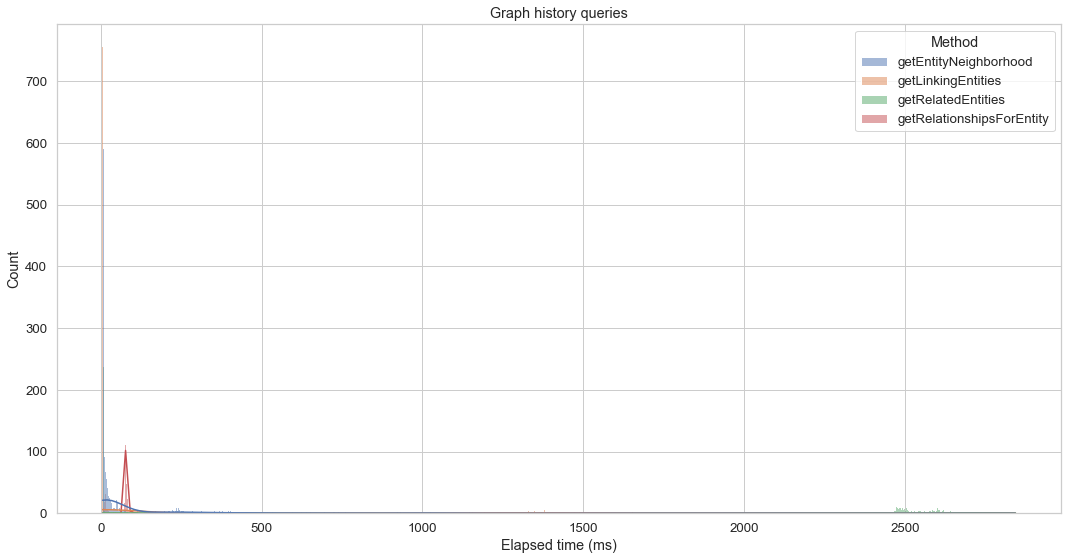

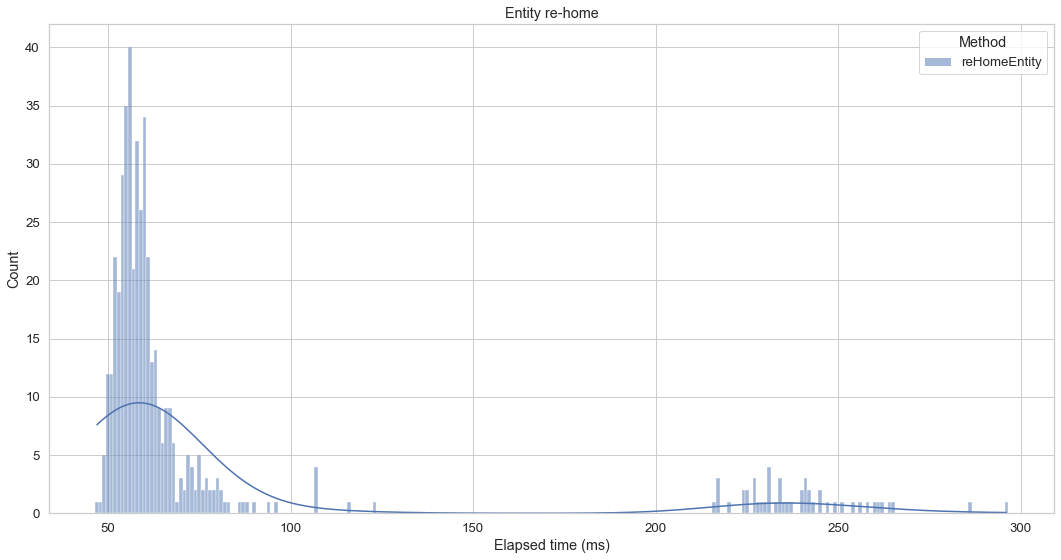

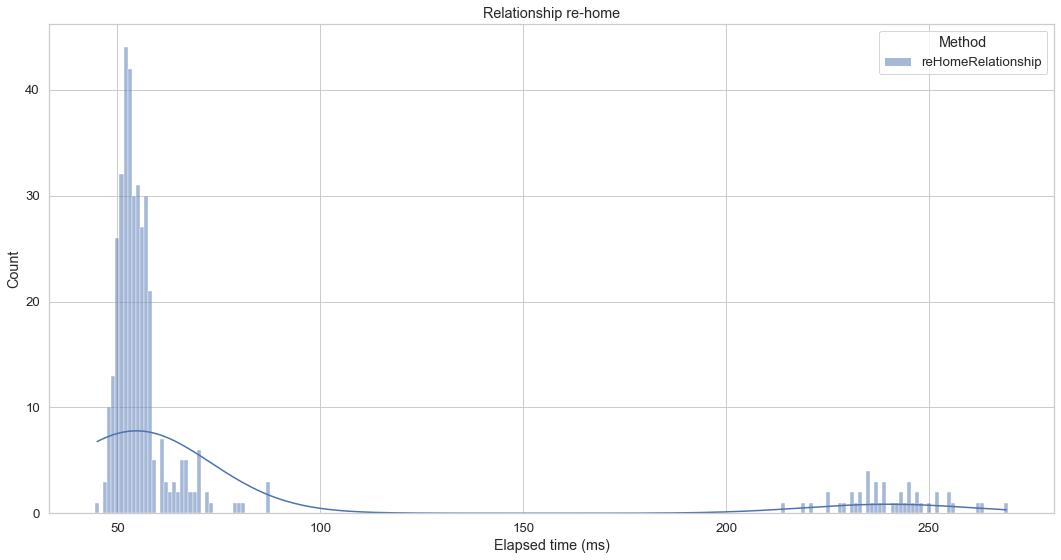

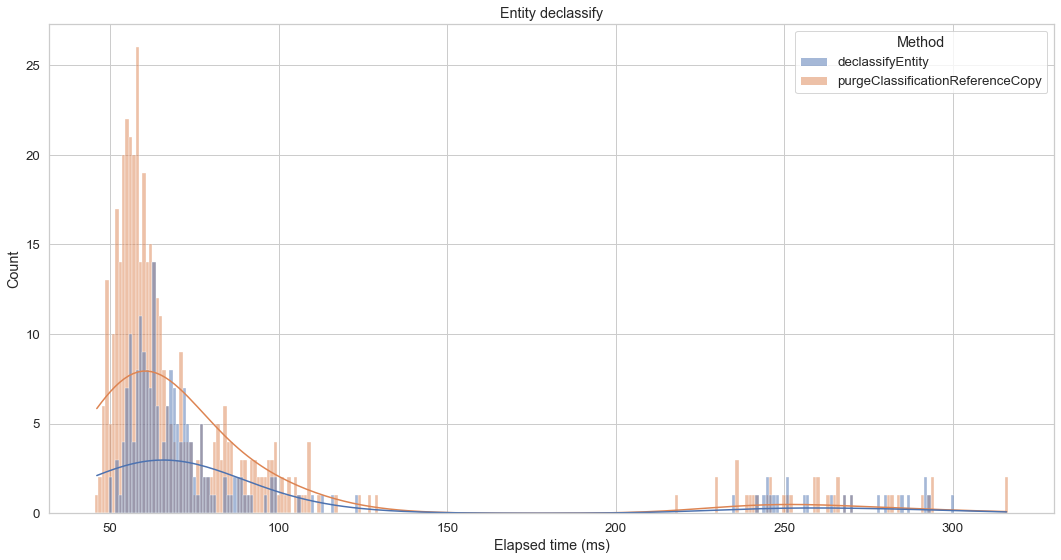

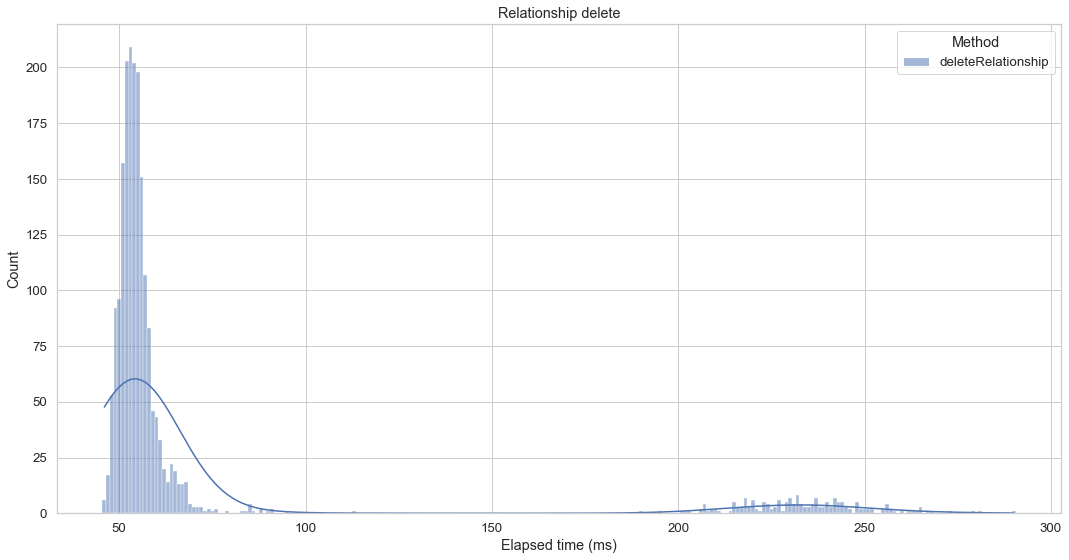

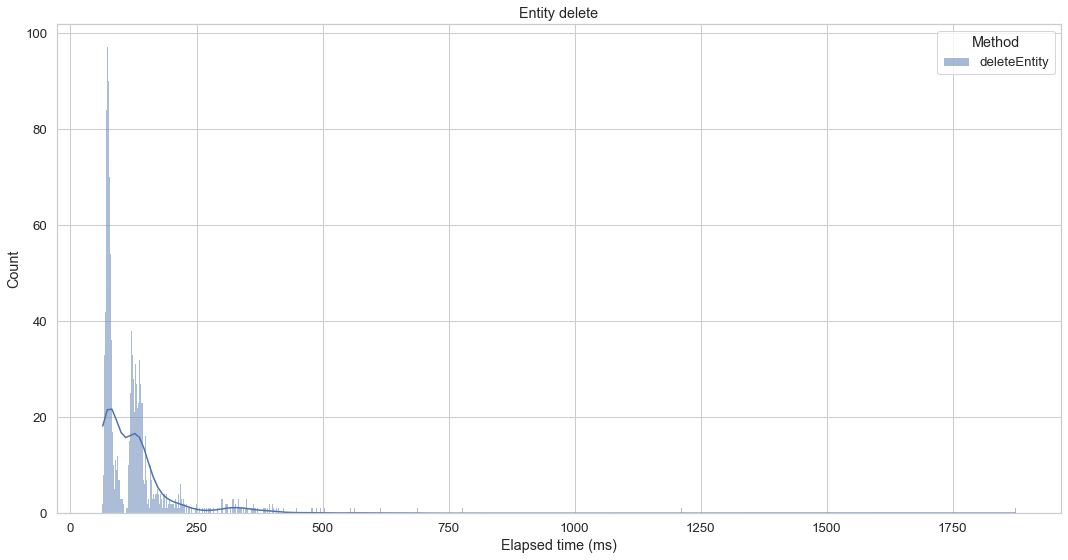

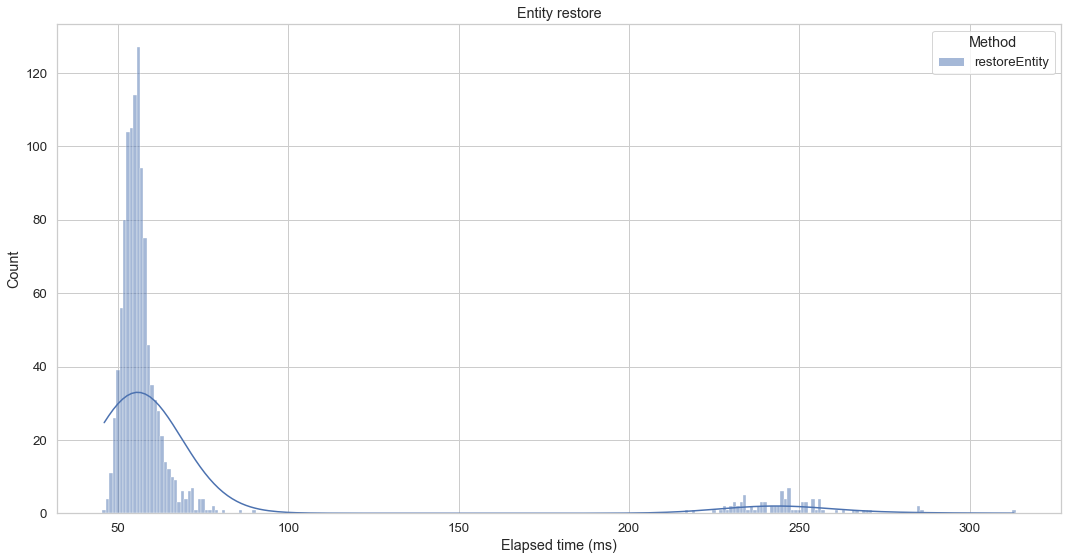

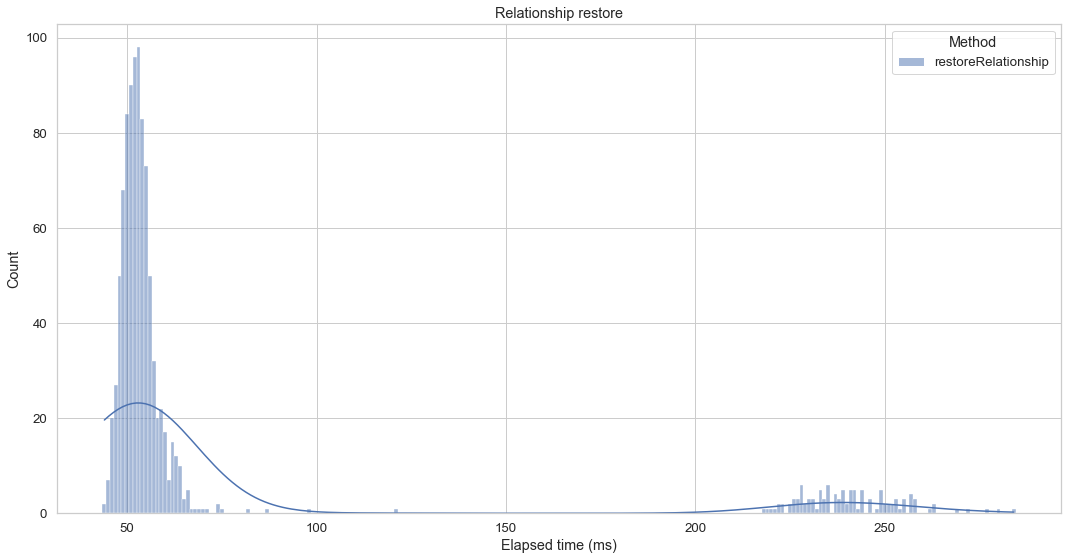

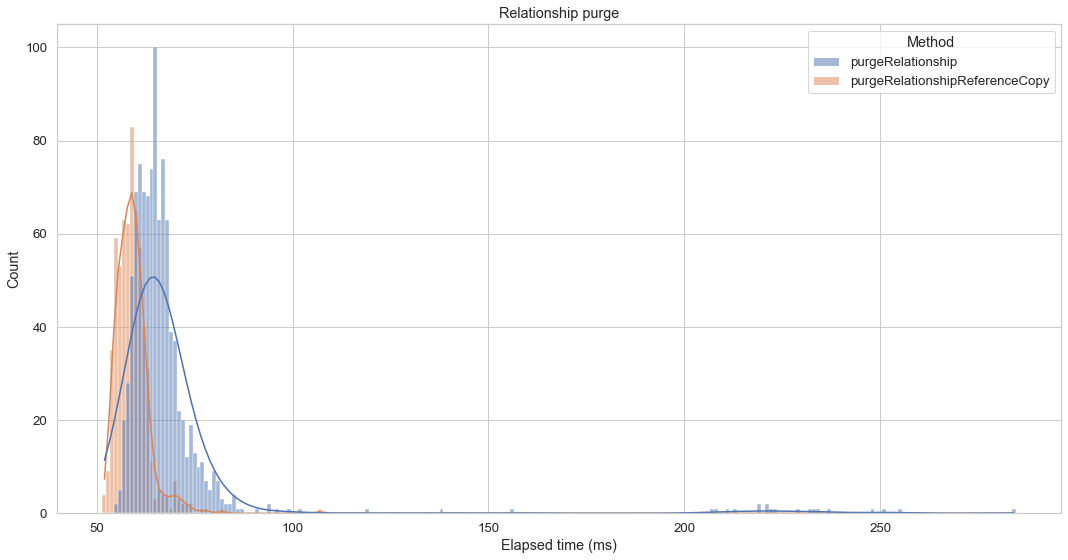

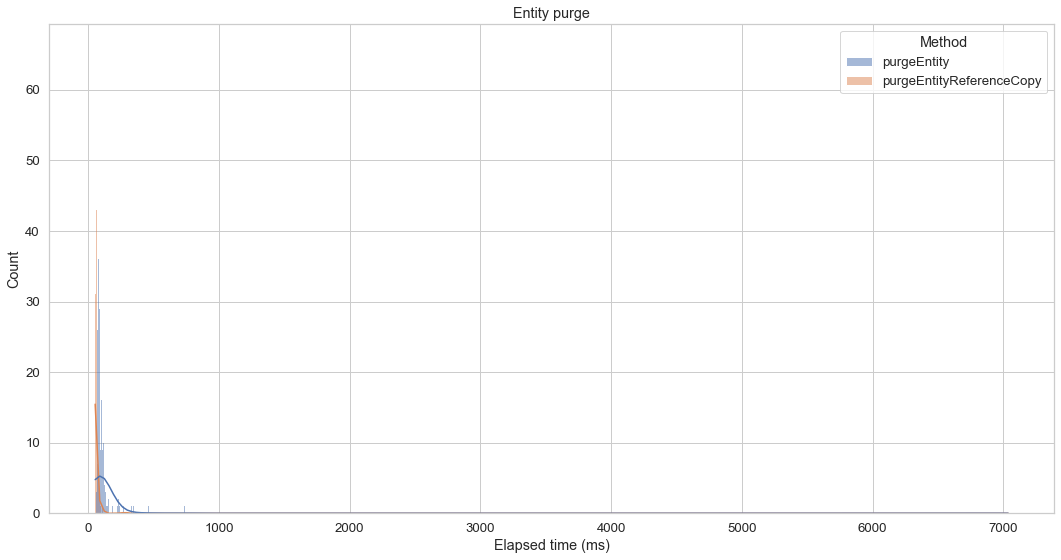

In [6]:
for profile in profile_order:
    plotProfile(df1, profile)

From these visualizations, we can quickly see the "typical" response times for a given method (where the peak(s) are highest) as well as the potential for extreme values (where there is a long-tail to the right that could extend up to several times longer than the "typical" response time).

For cases where we have such extreme values, we may want to better understand what specific set of parameters has caused that extreme response time: we can do this using the `slowestRunning` method. For example, the following will show us the 10-slowest-running search queries against entities:

In [7]:
slowestRunning(df1, 'Entity search', num=10)

,repo,method_name,elapsed_time,profile_name,test_case_id,assertion_id
41401,Crux,findEntities,800.0,Entity search,repository-entity-search-performance-Annotation,repository-entity-search-performance-findEntities-all-p31
42029,Crux,findEntities,643.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p36
41309,Crux,findEntities,628.0,Entity search,repository-entity-search-performance-APIOperation,repository-entity-search-performance-findEntities-all-p1
42030,Crux,findEntities,548.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p37
42031,Crux,findEntities,415.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p38
42027,Crux,findEntities,411.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p34
42060,Crux,findEntities,376.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p67
42045,Crux,findEntities,357.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p52
42036,Crux,findEntities,352.0,Entity search,repository-entity-search-performance-ComplexSchemaType,repository-entity-search-performance-findEntities-all-p43
50543,Crux,findEntitiesByProperty,341.0,Entity search,repository-entity-delete-performance-APIOperation,repository-entity-delete-performance-findEntitiesByProperty


The first entry in the table will be the slowest method in that entire profile: we can check its elapsed time under the `elapsed_time` column, the specific method that was called under the `method_name` column, and then determine more detail about that specific method invocation from the `test_case_id` column (which gives us information on the specific type definition that this method was called against) and the `assertion_id` column (which is unique to a particular point in the performance suite's testing code).

For example, if we see that:

- `method_name` = `findEntities`
- `elapsed_time` = `800`
- `test_case_id` = `repository-entity-search-performance-Annotation`
- `assertion_id` = `repository-entity-search-performance-findEntities-all-p31`

Then we can deduce that our slowest-running search was a `findEntities` method call that retrieved page 31 of the results for all `Annotation` entities, and that this took 800 milliseconds to complete.

Reviewing the other entries in the table is useful to determine whether this might be an outlier caused by something else occuring on the system (for example a garbage collection pause), or if there are other similar cases of extreme response times. (If this is the only number that seems to be at this extreme, you may want to re-run the performance suite with the same parameters to determine if you can produce the same result for this same type: if not, it is likely caused by some other area like garbage collection.)

If this does not appear to be a one-off outlier, then you will likely want to take this particular combination of parameters and do some more in-depth profiling and analysis of your repository to see what might be causing this extreme response time.

On the other hand, if you determine that actually the behavior is "random" rather than something inherent in the particular combination of parameters, you may instead want to simply remove such outliers and re-draw the plot for that profile without it, so that you have greater resolution on the more typical values:

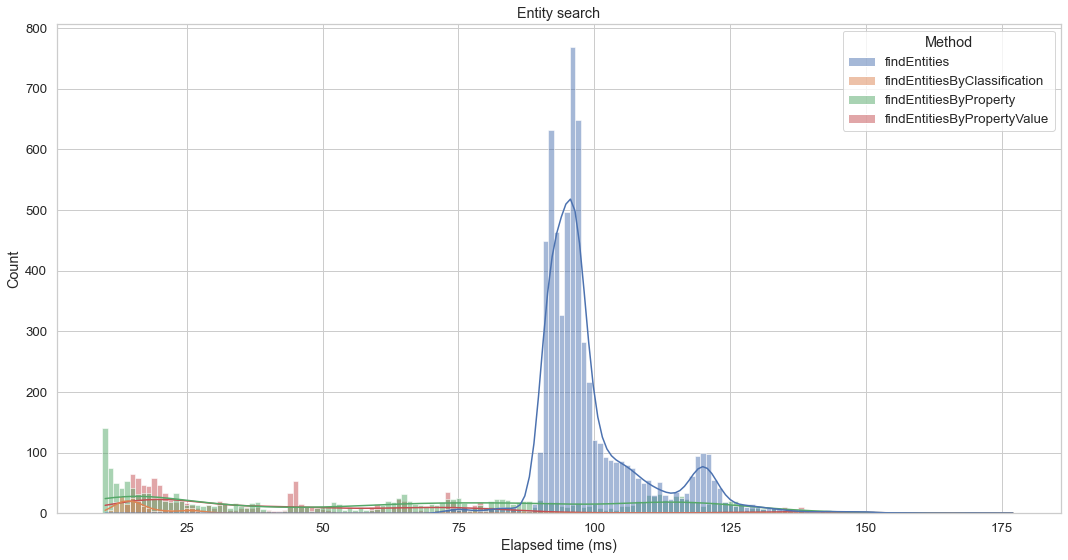

In [8]:
plotProfile(df1, 'Entity search', remove_outliers=True)

Without the outliers, we can more clearly see the typical distribution of each method's response times.

## Comparing results

Up to this point, we have done some analysis of the performance of a single repository on its own. However, we may also be interested in comparing and contrasting these results with either different performance test runs against that same repository (for example, after using different volume-controlling parameter settings, to investigate scalability), or by comparing performance test runs against other repositories.

In either case, we simply need to load those additional results and compare / contrast accordingly.

For example, start by defining a `secondary_results_location` below:

In [9]:
secondary_results_name     = "In-memory"
secondary_results_location = "inmem-5-2"

We can now re-use the methods defined earlier to validate, load and delve deeper into these results (note that we are re-using the same dataframe, which will now contain the combined results from both tests):

In [10]:
validateProfileResultsLocation(secondary_results_location)
secondary_files = getAllProfiles(secondary_results_location)
for profile_file in secondary_files:
    df1 = parseProfileDetailsIntoDF(df1, profile_file, secondary_results_name)

Validating profile-details location: inmem-5-2/profile-details
 ... directory exists.
Parsing evidence for: Relationship history search (In-memory)
Parsing evidence for: Classification update (In-memory)
Parsing evidence for: Graph queries (In-memory)
Parsing evidence for: Entity history retrieval (In-memory)
Parsing evidence for: Entity creation (In-memory)
Parsing evidence for: Relationship creation (In-memory)
Parsing evidence for: Entity history search (In-memory)
Parsing evidence for: Entity classification (In-memory)
Parsing evidence for: Entity retrieval (In-memory)
Parsing evidence for: Relationship history retrieval (In-memory)
Parsing evidence for: Relationship search (In-memory)
Parsing evidence for: Entity search (In-memory)
Parsing evidence for: Relationship retrieval (In-memory)
Parsing evidence for: Environment (In-memory)
Parsing evidence for: Classification search (In-memory)
Parsing evidence for: Graph history queries (In-memory)


## Visualizing side-by-side comparisons

Now that we have multiple results, we may want to use some additional visualizations to see the relative performance side-by-side. Following are some methods to do so:

### `compareProfiles`

Will plot the results from two different tests side-by-side for a given profile using a split violin plot. The violin plot shows a kernel density estimation distribution of the response time values for a given method, and is split between the two tests: one test's distribution showing on the left side and the other's on the right.

In simple terms: the higher a given plot goes, the slower the response times for that particular method; and the wider it is indicates the more frequently that particular reponse time was observed.

In [11]:
def compareProfiles(df, profileName, left, right, remove_outliers=False):
    dfX = df[df['profile_name'] == profileName]
    # Only attempt to plot if there is anything left in the dataframe
    if not dfX.empty:
        if remove_outliers:
            # If we have been asked to remove outliers, drop anything outside the 2nd and 98th percentiles
            dfX = dfX[dfX['elapsed_time'].between(dfX['elapsed_time'].quantile(.02), dfX['elapsed_time'].quantile(.98))]
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")
        fix, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
        # Display the methods within the profile in alphabetical order for consistency
        methods = dfX['method_name'].unique()
        figure = sns.violinplot(x="method_name", y="elapsed_time", ax=axs, hue="repo",
                                hue_order=[left, right], split=True, scale='count',
                                inner='quartile', cut=0, data=dfX)
        # If there are more than 4 methods in the profile, rotate them so they are still readable
        if (len(methods) > 4):
            figure.set_xticklabels(figure.get_xticklabels(), rotation=10)
        figure.set(xlabel="Method name", ylabel="Elapsed time (ms)")
        figure.set_title(profileName + ' comparison')
        figure.get_legend().set(title='Test')
        display(fix)
        plt.close(fix)

So for example, if we compare the two results' on their performance of the "Relationship retrieval" profile, we can quickly see whether the two are approximately the same speed or if one is generally faster than the other.

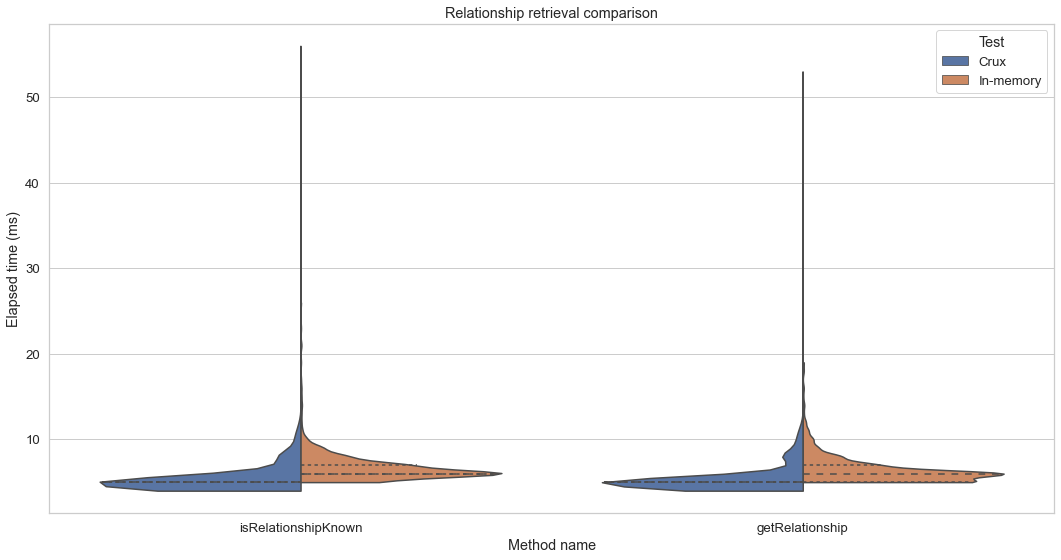

In [12]:
compareProfiles(df1, 'Relationship retrieval', primary_results_name, secondary_results_name)